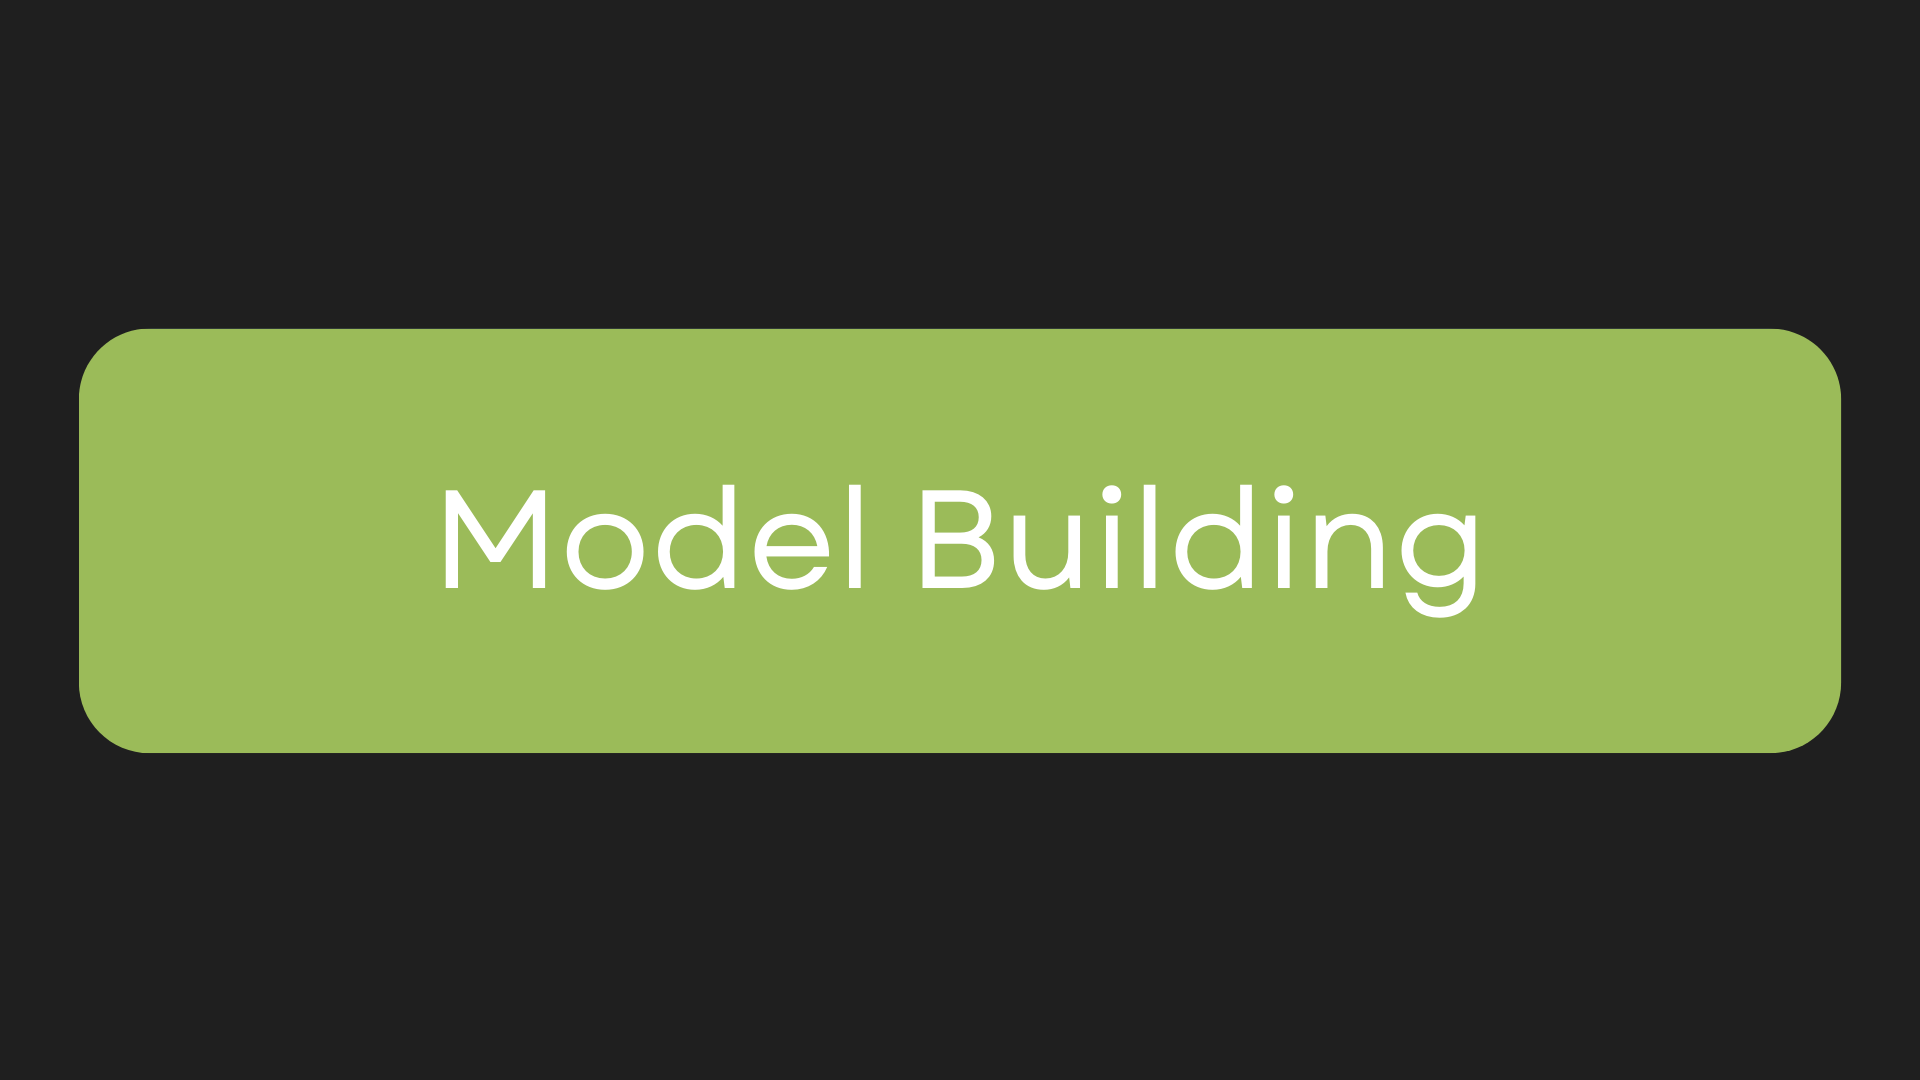



⌛ Let's create the CNN encoder. You should include:

1. Using the `torchvision.models`'s `resnet50` which is a well established model. Set the  `weights` parameter to the default ones using this line: `models.ResNet50_Weights.DEFAULT`. Set this to `resnet`

2. Remove the last layer of the `resnet` model using these lines:

`modules = list(resnet.children())[:-1]`

`self.resnet = nn.Sequential(*modules)`

`for param in self.resnet.parameters():`

            `param.requires_grad = False`

3. Add our own FC layer by setting `self.fc` to a new Linear layer using the `nn` module. The linear method should contain: `resnet.fc.in_features, embed_size`

4. Add dropout and flatten layers using the `nn` module

5. Execute forward pass through all your layers (resnet, flatten, fc, dropout)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchinfo import summary

In [2]:
# Use a pretrained ResNet Model as the encoder
class CNN_Encoder(nn.Module): 
    def __init__(self, embed_size):
        super().__init__()

        #CODE HERE
        resnet = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(resnet.fc.in_features, embed_size)
        self.dropout = nn.Dropout(0.5)

        self.flatten = nn.Flatten




    def forward(self, images):
        
        #CODE HERE
        features = self.resnet(images)
        features = self.flatten(features)

        features = self.fc(features)

        features = self.dropout(features)



⌛ Let's create the LSTM decoder. You should have:

1. Four layers from the `nn` module with correct parameters
    - An embedding layer
    - An LSTM layer
    - A linear layer
    - A dropout layer
2. Forward pass
    - Embed the captions using your dropout layer on the `captions` parameter
    - Append the encoder features
    - Pass the embeddings back through the LSTM
    - Get predictions (`outputs` variable) for each word using the FC layer and return the `outputs` and `states`

In [3]:
class LSTM_Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super().__init__()

        #CODE HERE
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)


    def forward(self, encoder_features, captions, states=None):

        #CODE HERE
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((encoder_features.unsqueeze(0), embeddings), dim=0)

        #get predictions
        lstm_output, states = self.lstm(embeddings, states)
        outputs = self.fc(lstm_output)

        
        return outputs, states


⌛ Let's create the CNN to LSTM.

In `__init__`:

1. Define the encoders and decoders with your previous functions above (`CNN_Encoder()` and `LSTM_Decoder()`) as `self.encoder` or `self.decoder`

In `forward`:

1. Encode the images and set it to `encoder_features`
2. Get outputs with the decoder and set it to `outputs`

In `caption_image`:

1. Set `torch.no_grad():` 
2. Encode the `image` (from the `caption_image` parameters). Set it to `encoder_features`
3. Start with the SOS (Start of sentence) token. Find it in our vocabulary using: `word_idx = vocabulary.word_to_index["< SOS >"]` and append it to our results
4. Embed our SOS token
5. Use the encoding features with the SOS token
6. Start prediciting every subsequent word until you hit an EOS token or reach max length
7. Convert indicies back to words and remove any special tokens. Return the output




In [4]:
class CNN_to_LSTM(nn.Module):
    def __init__(self, embed_size, hidden_size, num_layers, vocab_size):
        super().__init__()

        #CODE HERE
        self.encoder = CNN_Encoder(embed_size)
        self.decoder = LSTM_Decoder(embed_size, hidden_size, vocab_size, num_layers)


    def forward(self, images, captions):
        
        #CODE HERE
        encoder_features = self.encoder(images)

        outputs, _ = self.decoder(encoder_features, captions)
        
        return outputs

Strength test below to test our model

In [5]:
def strength_test():
    # Create tensors that match the dimensions from your dataset
    image_tensor = torch.randn([32, 3, 224, 224])  # 32 images from batch
    captions = torch.randint(0, 10000, (20, 32))   # 20 words for 32 captions

    # Initialize model with smaller dimensions for quicker testing
    model = CNN_to_LSTM(embed_size=256, hidden_size=256, num_layers=1, vocab_size=10000)

    summary(model, input_data=[image_tensor, captions])

    # Forward pass
    output = model(image_tensor, captions)
    
    # Print output shape
    print("Output tensor shape:", output.shape)
    print("Test completed successfully!")

if __name__ == "__main__":
    strength_test()
    

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/azureuser/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 172MB/s]


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, MaxPool2d: 3, Sequential: 3, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, Sequential: 5, Conv2d: 6, BatchNorm2d: 6, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Sequential: 3, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, Sequential: 5, Conv2d: 6, BatchNorm2d: 6, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Sequential: 3, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, Sequential: 5, Conv2d: 6, BatchNorm2d: 6, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Sequential: 3, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, Sequential: 5, Conv2d: 6, BatchNorm2d: 6, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Bottleneck: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, Conv2d: 5, BatchNorm2d: 5, ReLU: 5, AdaptiveAvgPool2d: 3]